In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12.0, 6.0]

import okama as ok

pd.options.display.float_format = "{:,.5f}".format
np.set_printoptions(precision=5)

%load_ext autoreload
%autoreload 2

In [2]:
ok.__version__

'1.5.0'

## DCF

In [146]:
assets = ['RGBITR.INDX', 'RUCBTRNS.INDX', 'MCFTR.INDX', 'GC.COMM']
assets1 = ["MCFTR.INDX", "GC.COMM"]
assets2 = ["SPY.US", "AGG.US", "GC.COMM"]

In [221]:
weights = [0.10, 0.10, 0.55, 0.25]

pf = ok.Portfolio(
    assets,
    ccy="RUB",
    weights=weights,
    first_date='2013-01',
    last_date='2024-12',
    inflation=True,
    # symbol="retirement_pf.PF",
    rebalancing_strategy=ok.Rebalance(period="year"),
)
print(pf)

symbol                                                       portfolio_8286.PF
assets                       [RGBITR.INDX, RUCBTRNS.INDX, MCFTR.INDX, GC.COMM]
weights                                                 [0.1, 0.1, 0.55, 0.25]
rebalancing_period                                                        year
rebalancing_abs_deviation                                                 None
rebalancing_rel_deviation                                                 None
currency                                                                   RUB
inflation                                                             RUB.INFL
first_date                                                             2013-01
last_date                                                              2024-12
period_length                                               12 years, 0 months
dtype: object


In [222]:
pf.symbol = "Portfolio.PF"

### Indexation Strategy

In [299]:
ind = ok.IndexationStrategy(pf)
ind.initial_investment = 10_000_000
ind.amount = -10_000_000 * 0.15 / 2
ind.frequency = "half-year"

d = {
    "2015-06": -5_900_000,
}

ind.time_series_dic = d
ind.time_series_discounted_values = False

pf.dcf.cashflow_parameters = ind  # assign the cash flow strategy to portfolio

In [275]:
print(ind)

Portfolio symbol                 Portfolio.PF
Cash flow initial investment         10000000
Cash flow frequency                 half-year
Cash flow strategy               fixed_amount
Cash flow amount               -450,000.00000
Cash flow indexation                  0.07289
dtype: object


In [276]:
ind.time_series_dic

{'2015-06': -5900000}

In [277]:
print(pf.dcf)

Portfolio symbol            Portfolio.PF
Monte Carlo distribution            norm
Monte Carlo period                    25
Cash flow strategy          fixed_amount
discount_rate                    0.07289
dtype: object


In [278]:
df2 = pf.dcf.wealth_index(discounting="fv", include_negative_values=False)
df2

,Portfolio.PF,RUB.INFL
2012-12,"10,000,000.00000","10,000,000.00000"
2013-01,"10,254,192.25000","10,097,000.00000"
2013-02,"9,981,385.80665","10,153,543.20000"
2013-03,"9,867,625.44662","10,188,065.24688"
2013-04,"9,539,053.86835","10,240,024.37964"
...,...,...
2024-08,0.00000,"22,359,285.23952"
2024-09,0.00000,"22,466,609.80867"
2024-10,0.00000,"22,635,109.38224"
2024-11,0.00000,"22,958,791.44640"


In [279]:
df1 = pf.dcf.cash_flow_ts(discounting="fv", remove_if_wealth_index_negative=True)
df1[df1 != 0]

date
2013-06     -450,000.00000
2013-12     -466,399.40860
2014-06     -483,396.46298
2014-12     -501,012.94323
2015-06   -6,419,271.42316
2015-12     -538,195.29925
2016-06     -557,808.82062
2016-12     -578,137.12011
2017-06     -599,206.24646
2017-12     -621,043.19773
Freq: M, Name: cashflow_ts, dtype: float64

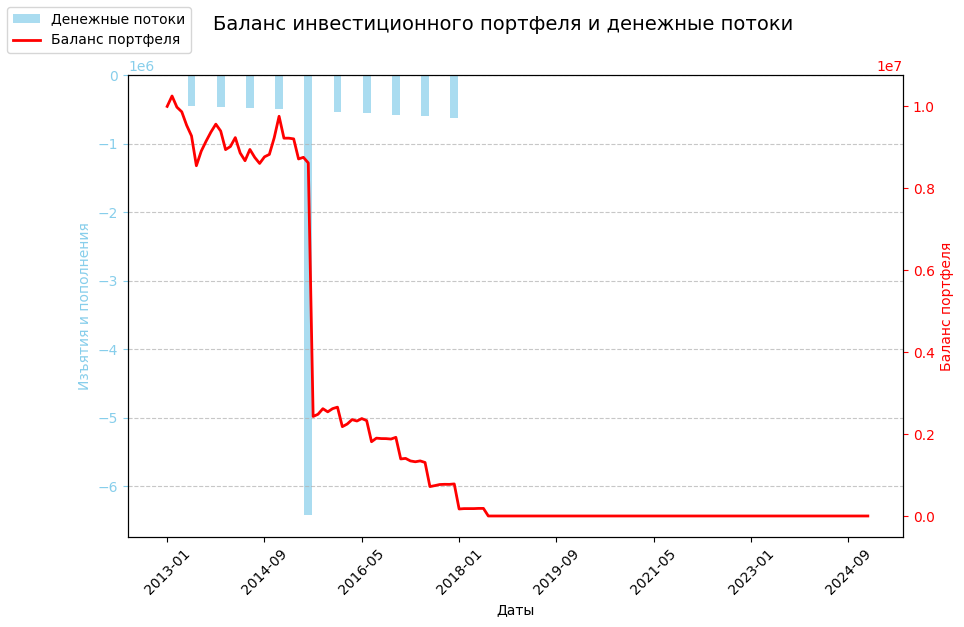

In [280]:
import matplotlib.figure as mfigure
import matplotlib.axes as maxes
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# 1. Создаем объект Figure
fig = mfigure.Figure(figsize=(10, 6))

# 2. Добавляем основную ось для столбчатой диаграммы
ax1 = fig.add_subplot()

# 3. Строим столбчатую диаграмму
bars = ax1.bar(
    x=np.arange(len(df1)),
    height=df1.values,
    width=1.6,
    color='skyblue',
    alpha=0.7,
    label='Денежные потоки'
)

# 4. Добавляем вторичную ось (для линейного графика)
ax2 = ax1.twinx()

# 5. Строим линейный график
line = ax2.plot(
    np.arange(len(df2)),
    df2['Portfolio.PF'].values,
    color='red',
    # marker='o',
    linestyle='-',
    linewidth=2,
    label='Баланс портфеля'
)[0]  # plot возвращает список линий

# 6. Настраиваем оформление
# Ось X: метки дат
ax1.set_xticks(np.arange(len(df1)))
ax1.set_xticklabels([d.strftime('%Y-%m') for d in df1.index], rotation=45)

# Подписи осей
ax1.set_xlabel('Даты')
ax1.set_ylabel('Изъятия и пополнения', color='skyblue')
ax2.set_ylabel('Баланс портфеля', color='red')

# настройка максимального количества подписей оси Х
from matplotlib.ticker import MaxNLocator
ax1.xaxis.set_major_locator(MaxNLocator(nbins=10)) 

# Цвета меток осей
ax1.tick_params(axis='y', colors='skyblue')
ax2.tick_params(axis='y', colors='red')

# Легенда (объединяем элементы с обеих осей)
from matplotlib.legend import Legend
handles = [bars, line]
labels = [h.get_label() for h in handles]
legend = Legend(fig, handles, labels, loc='upper left')
fig.artists.append(legend)

# Заголовок
fig.suptitle('Баланс инвестиционного портфеля и денежные потоки', fontsize=14)

# Сетка
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 7. Сохранение или отображение
# from matplotlib.backends.backend_agg import FigureCanvasAgg
# canvas = FigureCanvasAgg(fig)
# canvas.print_figure('combined_chart.png')  # Сохраняем в файл

# Для отображения в Jupyter:
from IPython.display import display
display(fig)

<Axes: xlabel='date'>

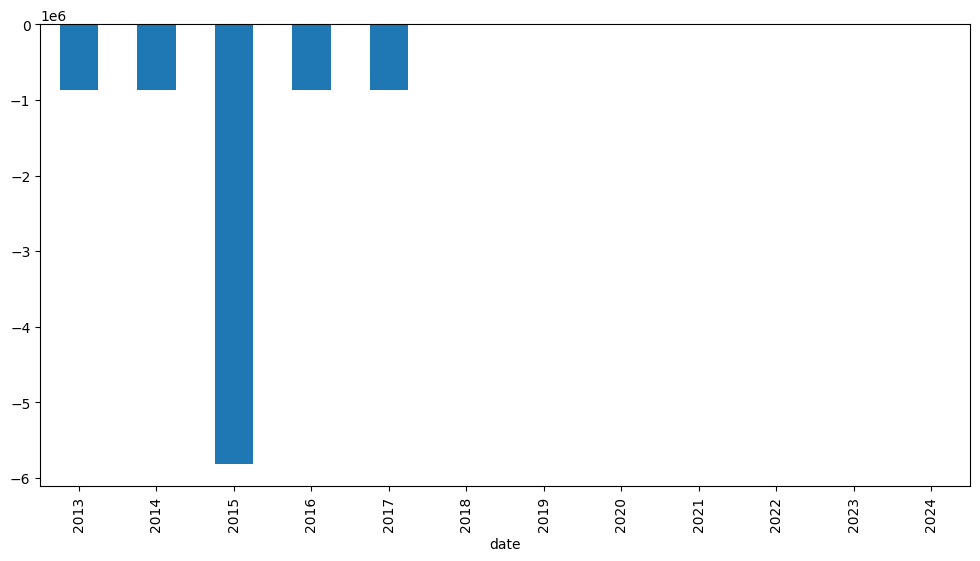

In [282]:
cf = pf.dcf.cash_flow_ts("pv", remove_if_wealth_index_negative=True)
cf.resample("Y").sum().plot(kind="bar")

<Axes: >

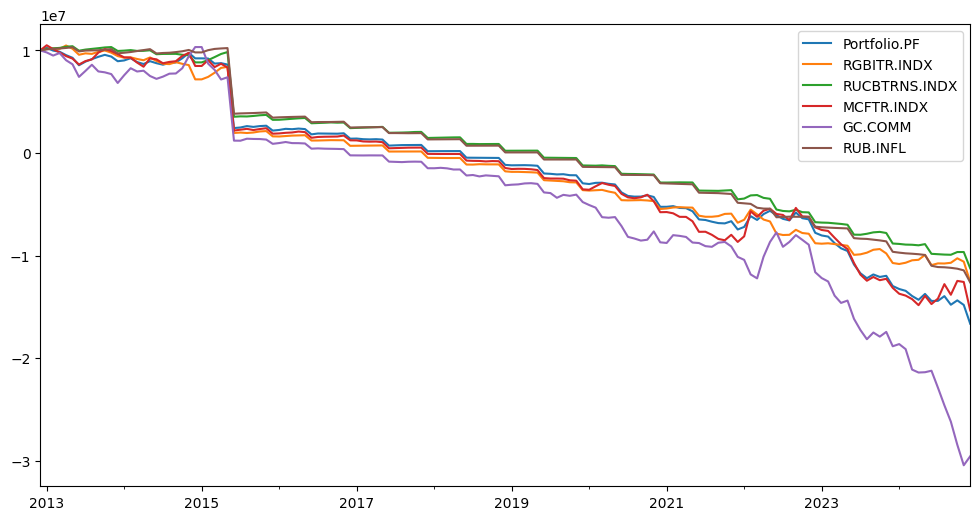

In [283]:
pf.dcf.wealth_index_fv_with_assets.plot()

### Монте-Карло Indexation

In [311]:
pf.dcf.set_mc_parameters(distribution="norm", period=25, number=100)  # Normal distribution (or Gaussian distribution)

In [312]:
df = pf.dcf.monte_carlo_wealth(discounting="pv", include_negative_values=False)

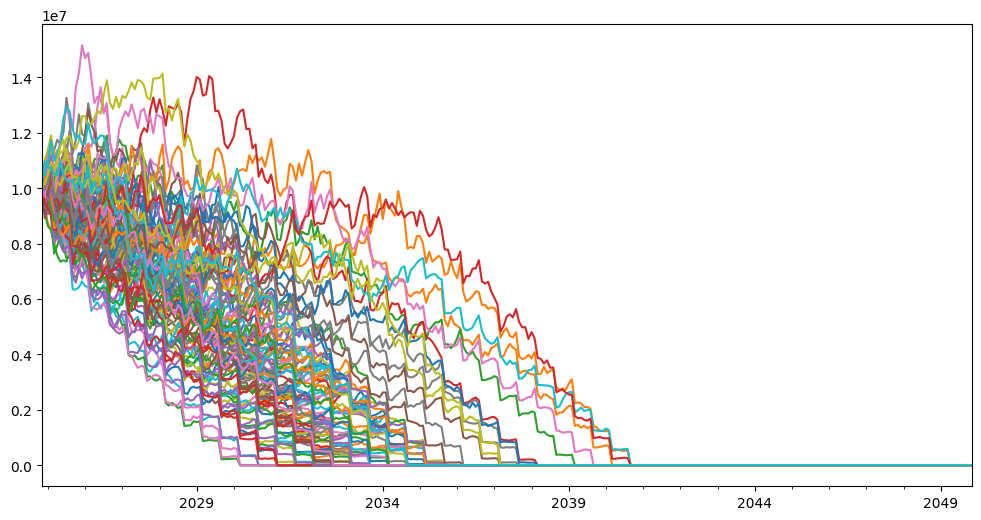

In [313]:
df.plot(legend=False)
plt.yscale('linear')  # linear or log

In [324]:
cf = pf.dcf.monte_carlo_cash_flow(discounting="pv", remove_if_wealth_index_negative=True)

<Axes: >

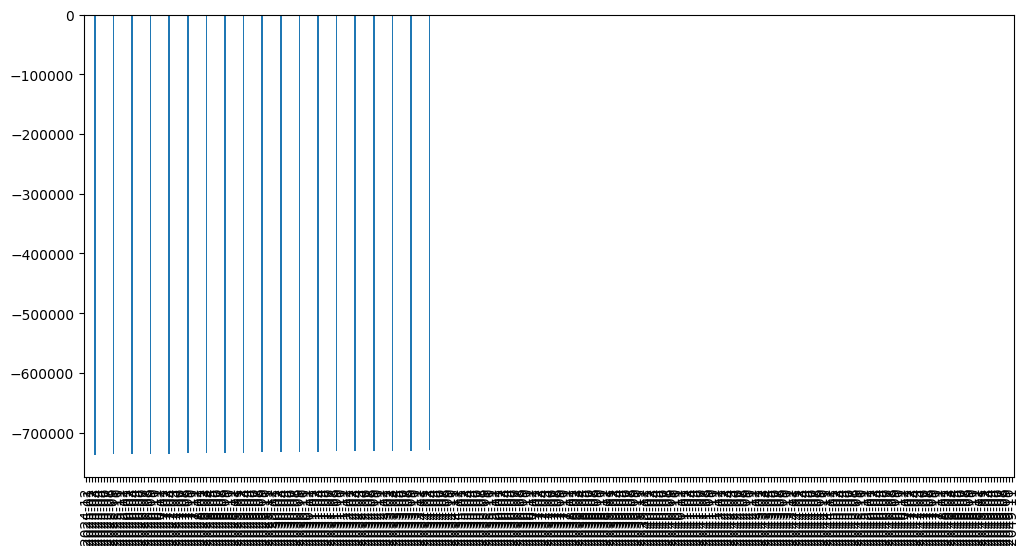

In [325]:
cf[0].plot(kind="bar")

In [15]:
pf.dcf.survival_date_hist(threshold=0)

Timestamp('2017-01-31 00:00:00')

In [22]:
pf.dcf.survival_period_hist()

13.3

<Axes: >

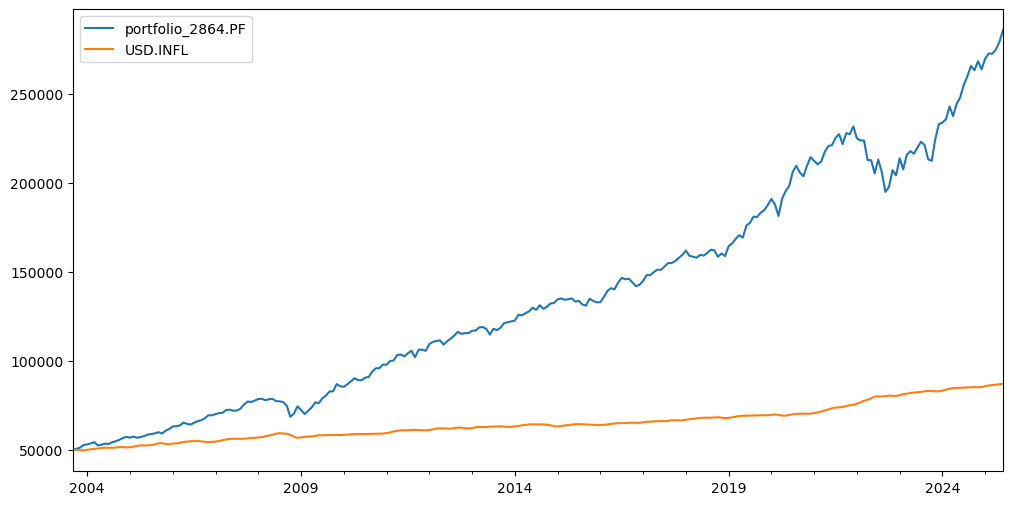

In [16]:
pf.dcf.wealth_index(discounting="fv", include_negative_values=False).plot()

### Fixed Percentage

In [239]:
# Fixed Percentage strategy
pc = ok.PercentageStrategy(pf)
pc.initial_investment = 10_000_000
pc.frequency = "month"
pc.percentage = -0.11
pc

Portfolio symbol                    Portfolio.PF
Cash flow initial investment            10000000
Cash flow frequency                        month
Cash flow strategy              fixed_percentage
Cash flow percentage                    -0.11000
dtype: object

In [240]:
# Assign a strategy
pf.dcf.cashflow_parameters = pc
# pf.dcf.discount_rate = 0.10
# pf.dcf.use_discounted_values = False

In [241]:
print(pf.dcf)

Portfolio symbol                Portfolio.PF
Monte Carlo distribution                norm
Monte Carlo period                        25
Cash flow strategy          fixed_percentage
discount_rate                        0.07289
dtype: object


In [242]:
print(pf)

symbol                                                            Portfolio.PF
assets                       [RGBITR.INDX, RUCBTRNS.INDX, MCFTR.INDX, GC.COMM]
weights                                                 [0.1, 0.1, 0.55, 0.25]
rebalancing_period                                                        year
rebalancing_abs_deviation                                                 None
rebalancing_rel_deviation                                                 None
currency                                                                   RUB
inflation                                                             RUB.INFL
first_date                                                             2013-01
last_date                                                              2024-12
period_length                                               12 years, 0 months
dtype: object


<Axes: >

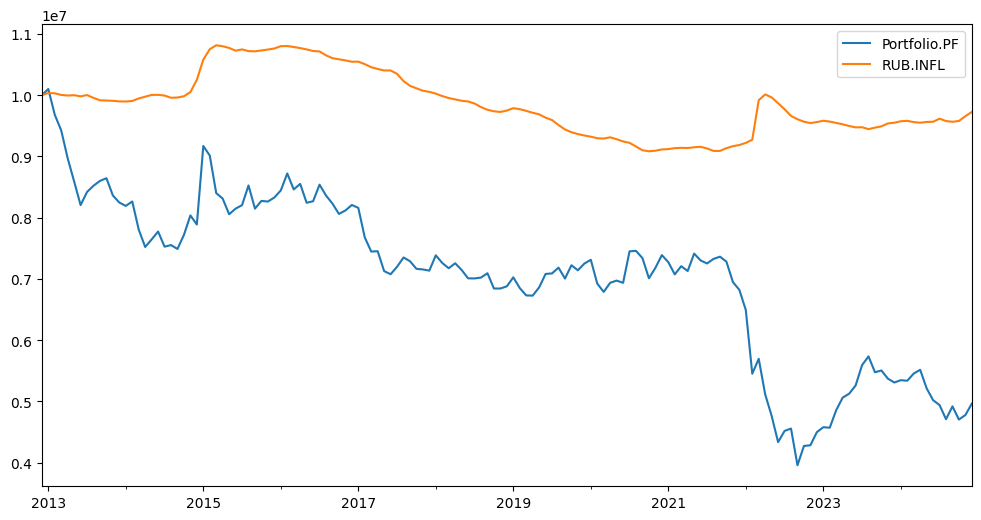

In [243]:
pf.dcf.wealth_index("pv").plot()

<Axes: >

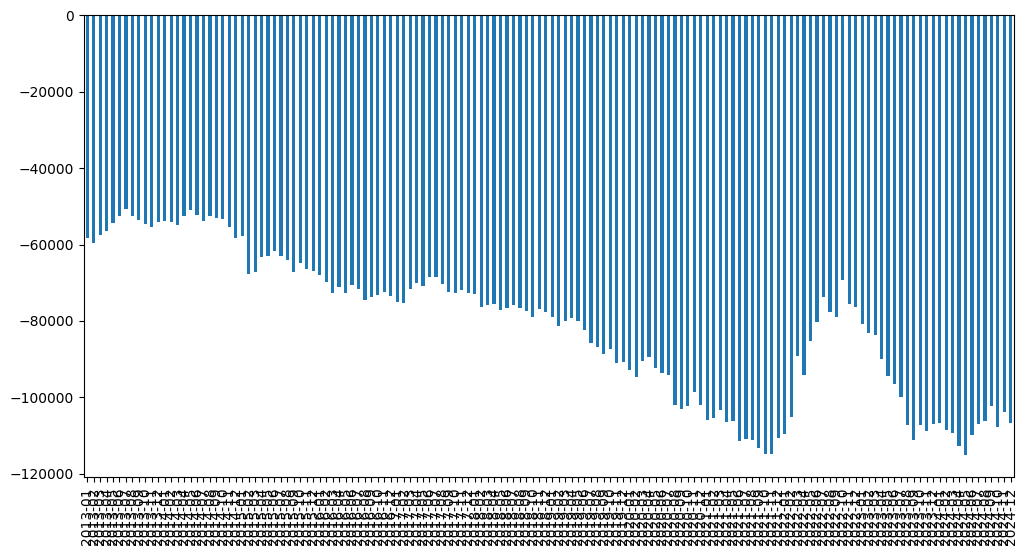

In [229]:
df = pf.dcf.cash_flow_ts("fv")
df[df != 0].plot(kind="bar")

In [230]:
df.iloc[0]

np.float64(-58333.333333333336)

### Монте-Карло Percentage

In [233]:
pf.dcf.set_mc_parameters(distribution="norm", period=25, number=100)  # Normal distribution (or Gaussian distribution)

In [234]:
df = pf.dcf.monte_carlo_wealth("pv")
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 301 entries, 2024-11 to 2049-11
Freq: M
Data columns (total 100 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       301 non-null    float64
 1   1       301 non-null    float64
 2   2       301 non-null    float64
 3   3       301 non-null    float64
 4   4       301 non-null    float64
 5   5       301 non-null    float64
 6   6       301 non-null    float64
 7   7       301 non-null    float64
 8   8       301 non-null    float64
 9   9       301 non-null    float64
 10  10      301 non-null    float64
 11  11      301 non-null    float64
 12  12      301 non-null    float64
 13  13      301 non-null    float64
 14  14      301 non-null    float64
 15  15      301 non-null    float64
 16  16      301 non-null    float64
 17  17      301 non-null    float64
 18  18      301 non-null    float64
 19  19      301 non-null    float64
 20  20      301 non-null    float64
 21  21      301 non-nul

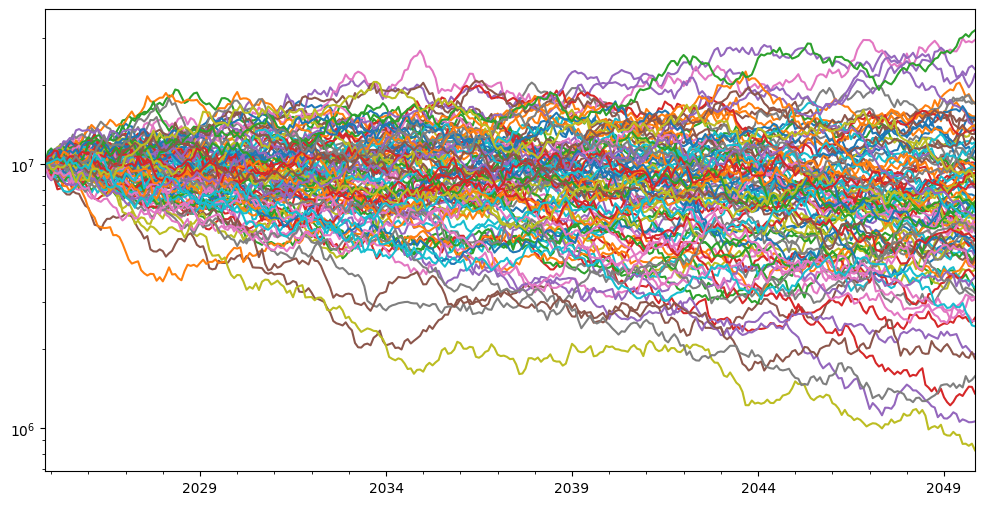

In [235]:
df.plot(legend=False)
plt.yscale('log')  # linear or log

In [236]:
cf = pf.dcf.monte_carlo_cash_flow_fv
cf.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 300 entries, 2024-12 to 2049-11
Freq: M
Data columns (total 100 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       300 non-null    float64
 1   1       300 non-null    float64
 2   2       300 non-null    float64
 3   3       300 non-null    float64
 4   4       300 non-null    float64
 5   5       300 non-null    float64
 6   6       300 non-null    float64
 7   7       300 non-null    float64
 8   8       300 non-null    float64
 9   9       300 non-null    float64
 10  10      300 non-null    float64
 11  11      300 non-null    float64
 12  12      300 non-null    float64
 13  13      300 non-null    float64
 14  14      300 non-null    float64
 15  15      300 non-null    float64
 16  16      300 non-null    float64
 17  17      300 non-null    float64
 18  18      300 non-null    float64
 19  19      300 non-null    float64
 20  20      300 non-null    float64
 21  21      300 non-nul

<Axes: >

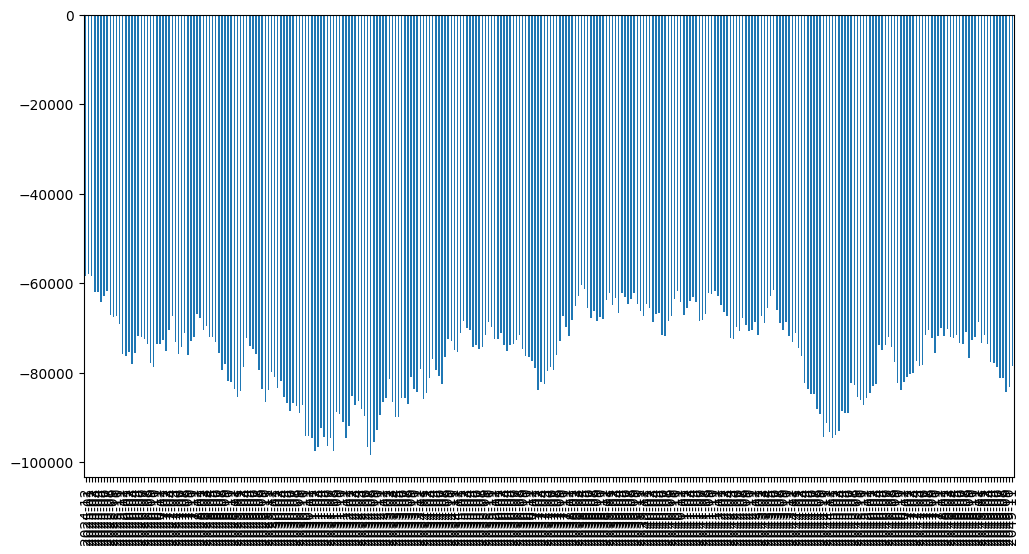

In [237]:
df = cf[0]
df[df != 0].plot(kind="bar")

In [238]:
cf_end = cf.iloc[-1]
cf_end.describe([.05, .20, .40, .70, .90])

count          100.00000
mean      -313,878.45768
std        272,091.99058
min     -1,963,455.97692
5%        -851,713.39693
20%       -453,517.06603
40%       -270,290.68999
50%       -218,262.56368
70%       -181,718.88048
90%       -104,689.24280
max        -21,719.48900
Name: 2049-11, dtype: float64

<Axes: ylabel='Frequency'>

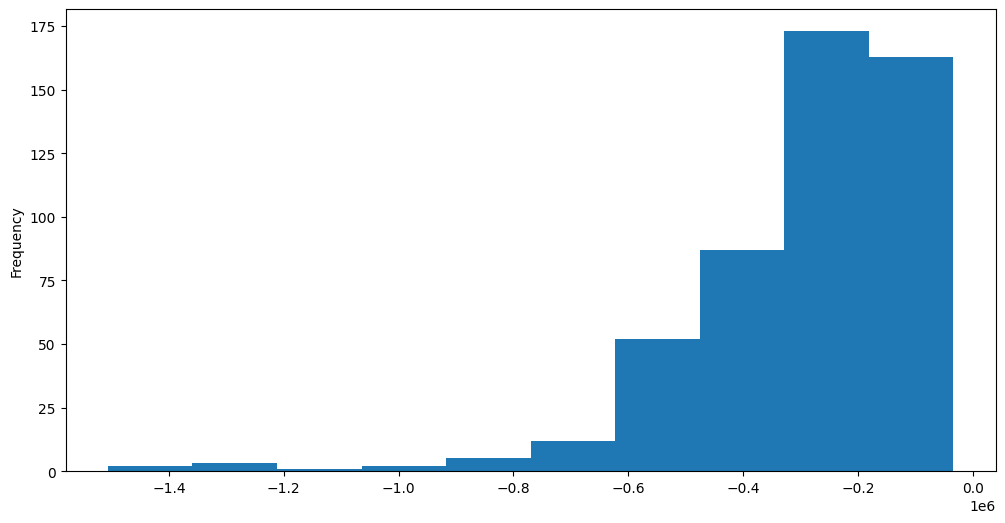

In [218]:
cf_end.plot(kind="hist")

### TimeSeries strategy

In [ ]:
d = {
    "2025-02": 1_000,
    "2029-03": -2_000,
}

d1 = {
    "2018-02": 2_000,
    "2024-03": -4_000,
}

ts = okama.portfolios.portfolio.cashflow_strategy.TimeSeriesStrategy(portf)
ts.initial_investment = 1_000
ts.time_series_dic = d1

ts

In [ ]:
# Assign a strategy
pf.dcf.cashflow_parameters = ts

In [23]:
pf.dcf

Portfolio symbol            portfolio_2953.PF
Monte carlo distribution                 norm
Monte carlo period                         25
Cash flow strategy           fixed_percentage
use_discounted_values                   False
dtype: object

In [8]:
# Set Monte Carlo
pf.dcf.set_mc_parameters(distribution="t", period=10, number=100)

In [14]:
pf.dcf.mc.period = 10

In [9]:
pf.dcf.mc.period

14

In [20]:
pf.dcf.cash_flow_parameters

AttributeError: 'PortfolioDCF' object has no attribute 'cash_flow_parameters'

In [20]:
pf.dcf.initial_investment_fv

<Axes: xlabel='date'>

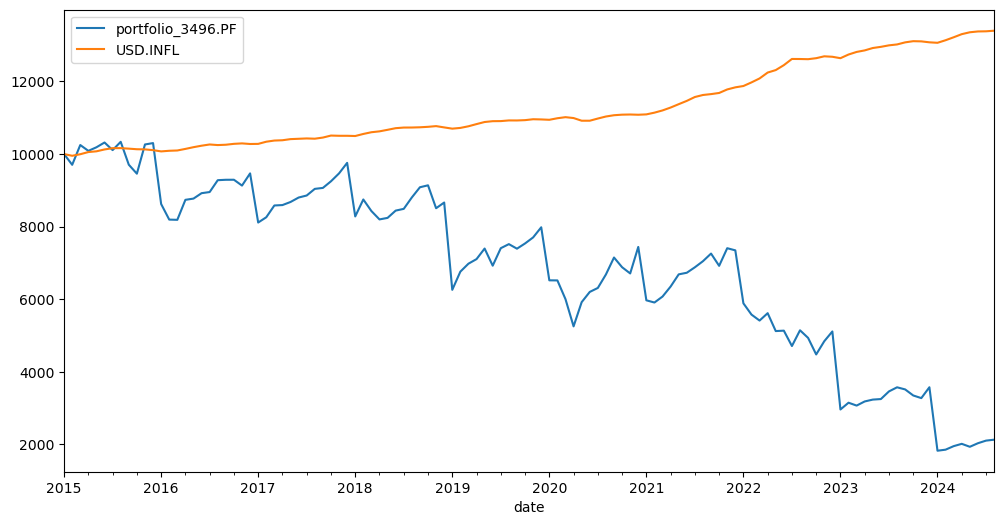

In [96]:
pf.dcf.wealth_index(discounting="fv", include_negative_values=False).plot()

In [9]:
df = pf.dcf.monte_carlo_wealth_pv

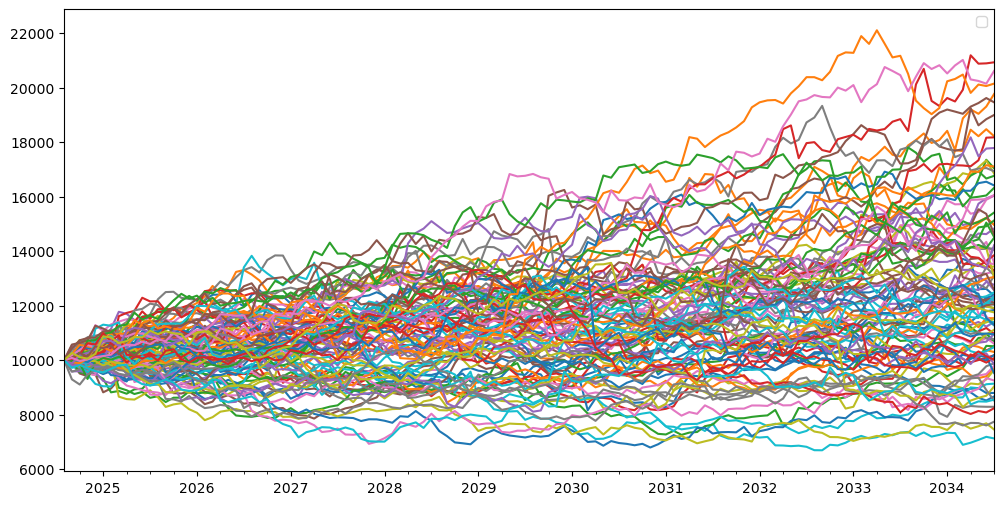

In [11]:
df.plot()
plt.legend("")

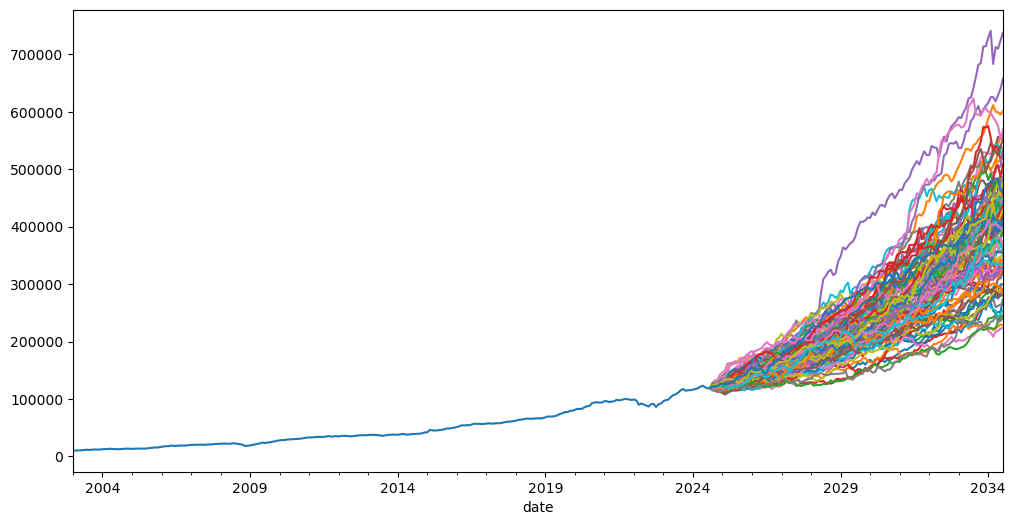

In [13]:
pf.dcf.plot_forecast_monte_carlo(backtest=True)

### find_the_largest_withdrawals_size

In [9]:
assets = ["RGBITR.INDX", "RUCBTRNS.INDX", "MCFTR.INDX", "GC.COMM"]
weights = [0.16, 0.40, 0.25, 0.19]
pf = ok.Portfolio(assets, weights=weights, ccy="RUB", rebalancing_strategy=ok.Rebalance(period="year"), inflation=False)
pf.dcf.discount_rate = 0.09
print(pf)

symbol                                                       portfolio_6436.PF
assets                       [RGBITR.INDX, RUCBTRNS.INDX, MCFTR.INDX, GC.COMM]
weights                                                [0.16, 0.4, 0.25, 0.19]
rebalancing_period                                                        year
rebalancing_abs_deviation                                                 None
rebalancing_rel_deviation                                                 None
currency                                                                   RUB
inflation                                                                 None
first_date                                                             2003-01
last_date                                                              2025-06
period_length                                               22 years, 6 months
dtype: object


In [10]:
ind = okama.portfolios.portfolio.cashflow_strategy.IndexationStrategy(pf)
ind.initial_investment = 2_000_000 * 90
ind.amount = -4000 * 90
ind.frequency = "month"
ind.indexation = 0.09

pf.dcf.cashflow_parameters = ind
print(ind)

Portfolio symbol                portfolio_6436.PF
Cash flow initial investment            180000000
Cash flow frequency                         month
Cash flow strategy                   fixed_amount
Cash flow amount                          -360000
Cash flow indexation                      0.09000
dtype: object


In [11]:
ind.amount * 12 / ind.initial_investment * 100

-2.4

In [12]:
pf.dcf.mc.period = 50
pf.dcf.mc.number = 100
pf.dcf.mc.distribution = "norm"

In [13]:
pf.dcf.monte_carlo_survival_period().describe()

count   100.00000
mean     48.90300
std       3.62024
min      29.40000
25%      50.00000
50%      50.00000
75%      50.00000
max      50.00000
dtype: float64

In [8]:
mc_wealth_pv = pf.dcf.monte_carlo_wealth_pv

In [9]:
mc50years_wealth_pv = mc_wealth_pv.iloc[-1, :]
mc50years_wealth_pv.describe([0.05, 0.20, 0.30, 0.50])

count              90.00000
mean      400,707,166.39629
std       331,212,582.94797
min         8,107,953.18626
5%         39,702,834.57472
20%       143,359,085.40553
30%       200,303,716.07043
50%       308,283,047.77550
max     1,797,835,507.07551
Name: 2075-02, dtype: float64

In [14]:
pf.dcf.find_the_largest_withdrawals_size(
    goal="maintain_balance_pv",
    percentile=20,
    tolerance_rel=0.10,
)

wealth_at_quantile=0.00, main_parameter=-15000000.000
error_rel=1.000, gradient=0.000
decreasing withdrawal
wealth_at_quantile=0.00, main_parameter=-7500000.000
error_rel=1.000, gradient=0.000
decreasing withdrawal
wealth_at_quantile=0.00, main_parameter=-3750000.000
error_rel=1.000, gradient=0.000
decreasing withdrawal
wealth_at_quantile=0.00, main_parameter=-1875000.000
error_rel=1.000, gradient=0.000
decreasing withdrawal
wealth_at_quantile=158558931.03, main_parameter=-937500.000
error_rel=0.119, gradient=-0.881
decreasing withdrawal
wealth_at_quantile=74328629.23, main_parameter=-468750.000
error_rel=0.587, gradient=0.468
decreasing withdrawal
wealth_at_quantile=203040683.89, main_parameter=-234375.000
error_rel=0.128, gradient=-0.459
increasing withdrawal
wealth_at_quantile=104638589.01, main_parameter=-351562.500
error_rel=0.419, gradient=0.291
decreasing withdrawal
wealth_at_quantile=183759035.91, main_parameter=-292968.750
error_rel=0.021, gradient=-0.398
solution found: -2929

success                    True
withdrawal_abs   -292,968.75000
withdrawal_rel          0.01953
error_rel               0.02088
attempts                      9
dtype: object

#### Fixed Percentage

In [15]:
# Fixed Percentage strategy
pc = okama.portfolios.portfolio.cashflow_strategy.PercentageStrategy(pf)
pc.initial_investment = 10_000
pc.frequency = "year"
pc.percentage = -0.12
print(pc)

Portfolio symbol                portfolio_6436.PF
Cash flow initial investment                10000
Cash flow frequency                          year
Cash flow strategy               fixed_percentage
Cash flow percentage                     -0.12000
dtype: object


In [16]:
pf.dcf.cashflow_parameters = pc

In [17]:
pf.dcf.mc.period = 50
pf.dcf.mc.number = 100
pf.dcf.mc.distribution = "norm"

In [18]:
sol = pf.dcf.find_the_largest_withdrawals_size(
    goal="maintain_balance_pv", percentile=20, tolerance_rel=0.10, threshold=0.05
)
sol

wealth_at_quantile=0.00, main_parameter=-1.000
error_rel=1.000, gradient=0.000
decreasing withdrawal
wealth_at_quantile=0.00, main_parameter=-0.500
error_rel=1.000, gradient=-0.000
decreasing withdrawal
wealth_at_quantile=0.06, main_parameter=-0.250
error_rel=1.000, gradient=-0.000
decreasing withdrawal
wealth_at_quantile=60.09, main_parameter=-0.125
error_rel=0.994, gradient=-0.006
decreasing withdrawal
wealth_at_quantile=1365.34, main_parameter=-0.062
error_rel=0.863, gradient=-0.131
decreasing withdrawal
wealth_at_quantile=5971.99, main_parameter=-0.031
error_rel=0.403, gradient=-0.461
decreasing withdrawal
wealth_at_quantile=11971.37, main_parameter=-0.016
error_rel=0.197, gradient=-0.206
increasing withdrawal
wealth_at_quantile=6993.80, main_parameter=-0.023
error_rel=0.301, gradient=0.103
decreasing withdrawal
wealth_at_quantile=9759.33, main_parameter=-0.020
error_rel=0.024, gradient=-0.277
solution found: -195.31 or 1.95% after 9 steps.


success                True
withdrawal_abs   -195.31250
withdrawal_rel      0.01953
error_rel           0.02407
attempts                  9
dtype: object

In [19]:
print(sol)

success                True
withdrawal_abs   -195.31250
withdrawal_rel      0.01953
error_rel           0.02407
attempts                  9
dtype: object


In [ ]:
sol.solutions